In [23]:
from pylab import *
import pandas as pd
from timeit import default_timer as timer
import sys
sys.path.insert(0,'/Users/zihengchen/Documents/ImageAlgorithm3D/code/')
from HGCalImageAlgo3D_cuda_kernel import *

demoevent = "id>80"
DatasetDir  = '/Users/zihengchen/Documents/HGCal/workplace/data/'
DatasetFile = 'CMSSW93X_pt35_pu000'
df = pd.read_hdf(DatasetDir+"input/"+DatasetFile+"_rechit.h5",key="table")
dfgen = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_gen.pkl")

In [24]:
AFFINITY_Z = 1,
KERNAL_R = 2,#cm
KERNAL_Z = 2,#cm
KERNAL_EXPC = 0.5, #cm
MAXDISTANCE = 200,#cm
DECISION_RHO_KAPPA = 10,
DECISION_NHD = 4,#cm
CONTINUITY_NHD = 6#cm

# 0.Load Events

In [25]:
dfevt = df.query(demoevent)
dfevt = dfevt.reset_index(drop=True)
x,y,z,e = np.array(dfevt.x),np.array(dfevt.y),AFFINITY_Z*np.array(dfevt.z),np.array(dfevt.energy)

# 1. Find rho and NearestHigher

In [26]:
start = timer()
nrech = np.int32(e.size)

x = x.astype(np.float32)
y = y.astype(np.float32)
z = z.astype(np.float32)
e = e.astype(np.float32)
rho     = np.zeros_like(e)
rhorank = np.zeros_like(e).astype(np.int32)
nh      = np.zeros_like(e).astype(np.int32)
nhd     = np.zeros_like(e)

d_x = cuda.mem_alloc(x.nbytes)
d_y = cuda.mem_alloc(y.nbytes)
d_z = cuda.mem_alloc(z.nbytes)
d_e = cuda.mem_alloc(e.nbytes)
d_rho     = cuda.mem_alloc(rho.nbytes)
d_rhorank = cuda.mem_alloc(rhorank.nbytes)
d_nh      = cuda.mem_alloc(nh.nbytes)
d_nhd     = cuda.mem_alloc(nhd.nbytes)

start = timer()
cuda.memcpy_htod(d_x,x)
cuda.memcpy_htod(d_y,y)
cuda.memcpy_htod(d_z,z)
cuda.memcpy_htod(d_e,e)

rho_cuda(d_rho,
         nrech, np.float32(KERNAL_R), np.float32(KERNAL_Z), np.float32(KERNAL_EXPC),
         d_x,d_y,d_z,d_e,
         grid=(int(nrech/1024)+1,1,1),block=(int(1024),1,1))

rhoranknh_cuda(d_rhorank,d_nh,d_nhd,
               nrech,d_x,d_y,d_z,d_rho,
               grid=(int(nrech/1024)+1,1,1),block=(int(1024),1,1))

#rhorank_cuda(d_rhorank,nrech,d_rho,
#             grid=(int(nrech/1024)+1,1,1),block=(int(1024),1,1))

#nh_cuda(d_nh,d_nhd,
#        nrech,d_x,d_y,d_z,d_rho,
#        grid=(int(nrech/1024)+1,1,1),block=(int(1024),1,1))

cuda.memcpy_dtoh(rho,d_rho)
cuda.memcpy_dtoh(rhorank,d_rhorank)
cuda.memcpy_dtoh(nh,d_nh)
cuda.memcpy_dtoh(nhd,d_nhd)
end = timer()
print("number of rechits: {}".format(nrech))
print("time: {:3.6} ms".format(1000*(end - start)))

d_x.free()
d_y.free()
d_z.free()
d_e.free()
d_rho.free()
d_rhorank.free()
d_nh.free()
d_nhd.free()

number of rechits: 18581
time: 287.602 ms


# 2. Asign Clusters

In [27]:
cluster = -np.ones(nrech,int)
DECISION_RHO = rho.max()/DECISION_RHO_KAPPA

# 2.1 convert rhorank to argsortrho 0(N)
argsortrho = np.zeros(nrech,int)
argsortrho[rhorank] = np.arange(nrech)

# 2.2 find seeds
selectseed = (rho>DECISION_RHO) & (nhd>DECISION_NHD)
seedrho = rho[selectseed]
temp = seedrho.argsort()[::-1]
seedid = np.empty(len(seedrho), int)
seedid[temp] = np.arange(len(seedrho))
cluster[selectseed] = seedid
dfevt['isseed'] = pd.Series(selectseed.astype(int), index=dfevt.index)

# 2.3 asign clusters to seeds
for ith in range(nrech):
    i = argsortrho[ith]
    if  (cluster[i]<0) & (nhd[i]<CONTINUITY_NHD):
        cluster[i] = cluster[nh[i]]

In [28]:
dfevt['rho'] = pd.Series(rho, index=dfevt.index)
dfevt['rhorank'] = pd.Series(rhorank, index=dfevt.index)
dfevt['nh'] = pd.Series(nh, index=dfevt.index)
dfevt['nhd'] = pd.Series(nhd, index=dfevt.index)
dfevt['cluster'] = pd.Series(cluster, index=dfevt.index)

# Make Plots

In [29]:
%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

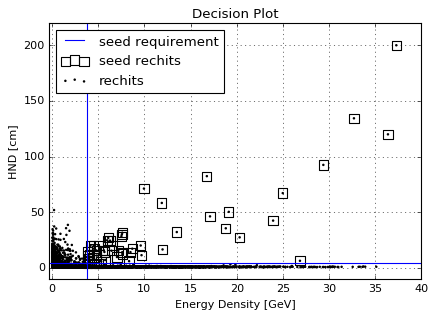

In [30]:
plt.scatter(dfevt.rho[selectseed],dfevt.nhd[selectseed],marker='s',
            s=70,edgecolor="k",color="None",label="seed rechits")
plt.scatter(dfevt.rho,dfevt.nhd,marker='.',edgecolor="None",color="k",label="rechits")
plt.axvline(DECISION_RHO,color="b",label="seed requirement")
plt.axhline(DECISION_NHD,color="b")

plt.xlabel("Energy Density [GeV]")
plt.ylabel("HND [cm]")
plt.legend(loc="upper left",fontsize=12)
plt.xlim(-0.3)
plt.ylim(-10,220)
plt.grid(True)
plt.title("Decision Plot",fontsize=12)

plt.savefig("../../plot/decision_cuda.png")

In [31]:
gen = dfgen.query(demoevent)

In [32]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)

dfevt = dfevt.reset_index(drop=True)

tempdf = dfevt.query('cluster>-1')
tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,tempdf.cluster.max()-tempdf.cluster
rechits = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=5*tempe**0.5,color=tempclst,colorscale='Jet',cmax=tempclst.max(),cmin=0,opacity=0.5,
                                   line = dict(width = 0))) 
#tempdf = dfevt.query('(cluster==-1)')
tempdf = dfevt.query('(cluster==-1) & (energy>0.02)')

tempx,tempy,tempz,tempe,tempclst = tempdf.ox,tempdf.oy,tempdf.oz,tempdf.energy,-1
noise   = go.Scatter3d(x=tempx,y=tempz,z=tempy,
                       mode='markers',
                       marker=dict(size=0.7,color="black",opacity=0.1,
                                   line = dict(width = 0))) 

#genpart = go.Scatter3d(x=np.array([0,gen.gx]),
#                       y=np.array([0,gen.gz]),
#                       z=np.array([0,gen.gy]),
#                       mode='lines',marker=dict(size=0,color="red",opacity=1)) 

data = [rechits,noise]
layout = go.Layout(scene=dict(xaxis=dict(title='x (cm)'), yaxis=dict(title='z (cm)'), zaxis=dict(title='y (cm)')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='SinglePi_PU200')

'https://plot.ly/~zihengchen/18'